# Modeling

In [1]:
# import libraries 
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

Opening the cleaned dataframe:

In [2]:
develop_houses = pd.read_csv('KC_Data/filtered_data.csv', index_col = 0)

In [3]:
develop_houses.shape

(26709, 27)

Use heatmap to plot all the features and target to see the correlation

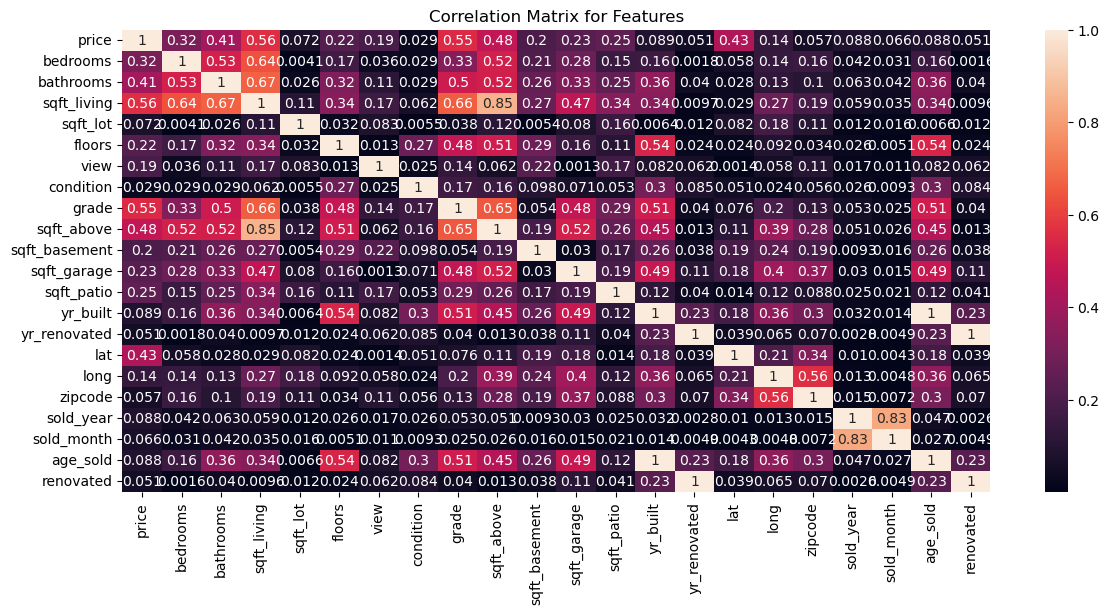

In [4]:
plt.figure(figsize=(14, 6))
sns.heatmap(develop_houses.corr(numeric_only = True).abs(), annot=True)

plt.title('Correlation Matrix for Features')
plt.savefig("corrmat.jpg", dpi = 300)
plt.show()

From this chart, sqft_living has the highest correlation with price at ~0.56. We can use this sqft_living as a feature in the baseline model with the price.

Drop features with low features: 'sold_year', 'sold_month', 'long','lat'

# Baseline model

In [5]:
develop_houses.shape

(26709, 27)

Using LinearRegression from Scikitlearn module to create linear model. Also, excecute the predictive model at the same time to validate the linear regression model by looking at the MAE (Mean Absolute Error) and residuals if residuals are normal distributed.

In [6]:
lr = LinearRegression()
lr

LinearRegression()

Build up the linear model on train dataset from 'develop_houses' after exclude 30% of the test dataset

In [7]:
X = develop_houses[['sqft_living']]
# X_augmented = sm.add_constant(X)
y = develop_houses['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(len(X_train))
print(len(X_test))
result_baseline = lr.fit(X_train, y_train)

18696
8013


In [8]:
result_baseline = lr.fit(X_train, y_train)
rsquared_baseline = lr.score(X_train, y_train)
y_pred = lr.predict(X_test)
MAE_baseline = mean_absolute_error(y_test, y_pred)

Add param of every model into a table for easy follow up

In [9]:
# Define table as a dataframe with specific columns. Each column's values will be a list that we will add to.
model_table = pd.DataFrame({'Model': [], 'Description':[], ' Num Features' : [], 'R-squared':[], 'MAE': []})

# Add data for simple linear regression
model_table.loc[0] = ['Baseline Linear Regression', 'Sqft_living', X.shape[1], round(rsquared_baseline,3)
                          , round(MAE_baseline,3) ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778


The baseline with R2 at ~32% and MAE with 284K, meaning that ~32% of variance in 'price' explains by variance of 'sqft_living' while MAE(Mean Absolute Error) explains the average absolute error between actual(y_test) and predicted values(y_pred)

Re_check with OLS model

In [10]:
result_baseline_OLS = sm.OLS(y_train,sm.add_constant(X_train)).fit()
# result_baseline_OLS.summary()

Try another way to plots all the charts

eval_env: 1


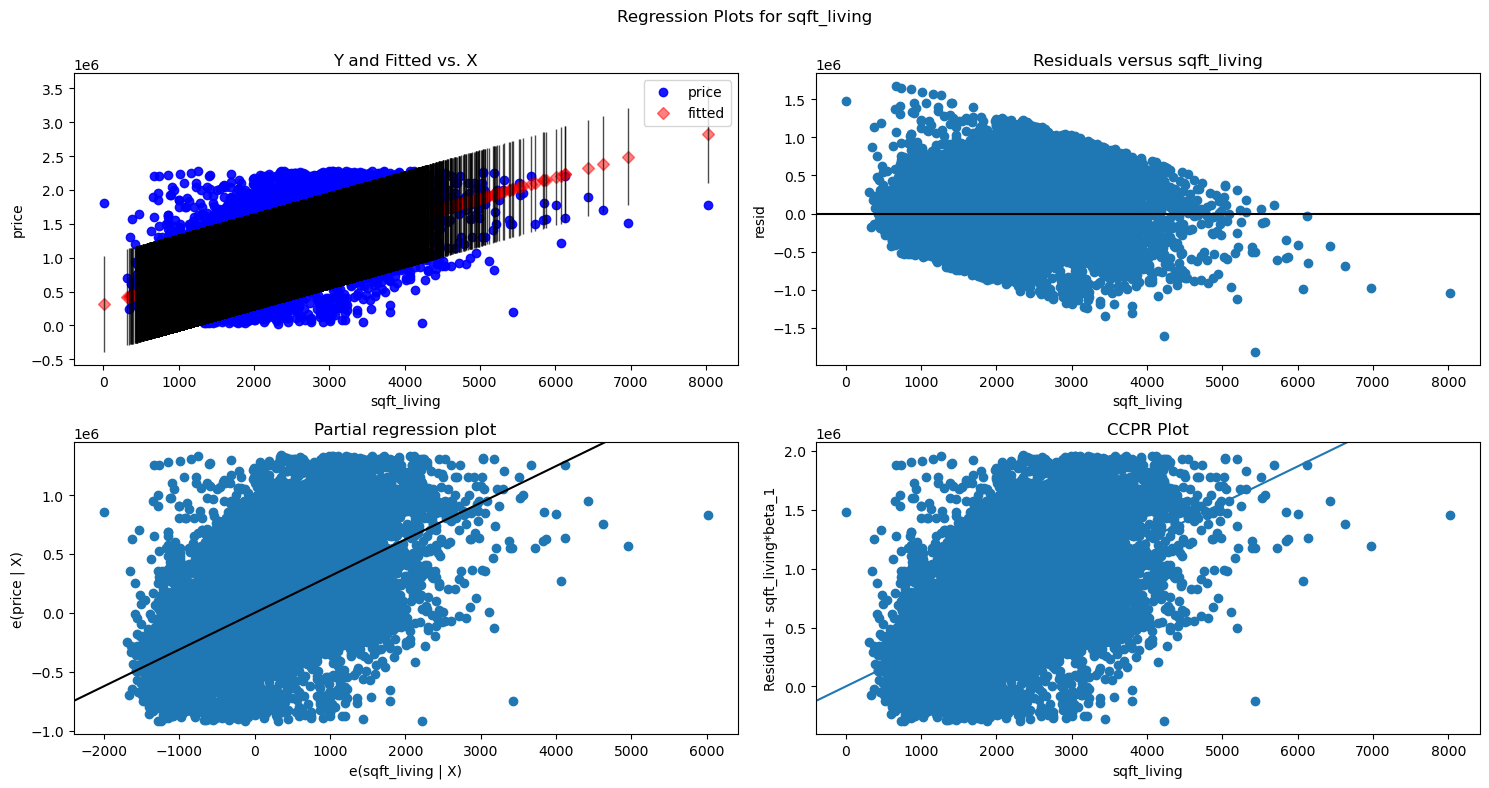

In [11]:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_regress_exog(result_baseline_OLS, "sqft_living", fig=fig)
plt.show()

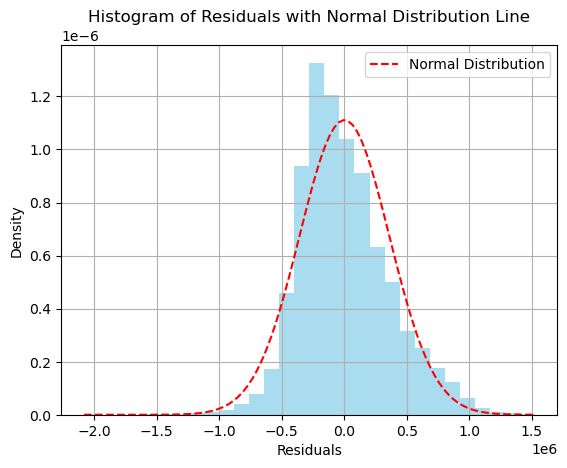

In [117]:
residuals = y_test - y_pred
# Plot the histogram
residuals.hist(bins=30, density=True, alpha=0.7, color='skyblue')

# Compute mean and standard deviation of residuals
mean = residuals.mean()
std = residuals.std()

# Create an array of values to plot the normal distribution line
x = np.linspace(residuals.min(), residuals.max(), 100)
y = stats.norm.pdf(x, mean, std)

# Plot the normal distribution line
plt.plot(x, y, color='red', linestyle='--', label='Normal Distribution')

# Add labels and legend
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Histogram of Residuals with Normal Distribution Line')
plt.legend()

# Show the plot
plt.show()


# 1ST MODEL

Analyze numeric features first.

Add in 2nd features which is 'sqft_lot', even though its correlation with price is low, but let's try to see how it will impacted on R2 and MAE or not.

In [13]:
X1 = develop_houses[['sqft_living','sqft_lot']]
y = develop_houses['price']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.3)
result_1 = lr.fit(X1_train, y1_train)
rsquared_1 = lr.score(X1_train, y1_train)
print('rsquared:', rsquared_1)
y1_pred = lr.predict(X1_test)
MAE_1 = mean_absolute_error(y1_test, y1_pred)
print('MAE_1:', MAE_1)

rsquared: 0.31457812757913295
MAE_1: 282754.4210665848


In [14]:
# Add data:
model_table.loc[1] = ['1st model', 'Sqft_living, sqft_lot', X1.shape[1], round(rsquared_1,3)
                         , MAE_1 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067


When 'sqft_lot' is added into the model, MAE increases while R-Square slightly goes up. Meaning that 'sqft_lot' does not impact much on model and we can take it out and try with another features.

In [15]:
#Calculate results by OLS model for visualization purpose
results_1_OLS = sm.OLS(y1_train,sm.add_constant(X1_train)).fit()
# results_1_OLS.summary()

eval_env: 1
eval_env: 1


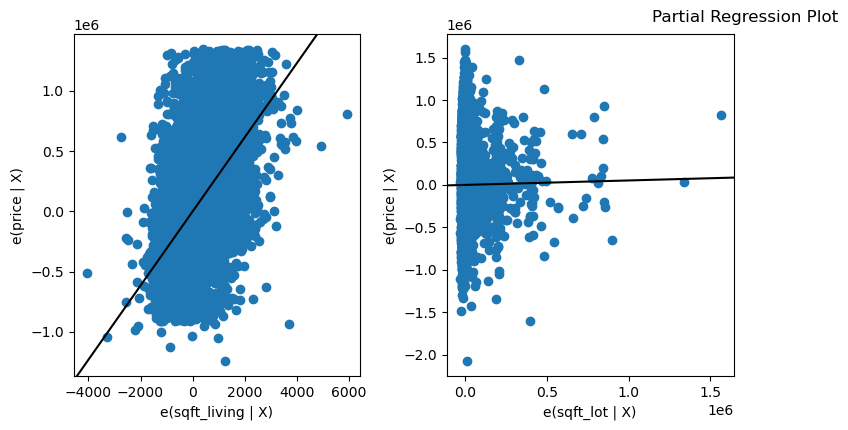

In [16]:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    results_1_OLS,
    exog_idx=list(X1_train.columns.values),
    grid=(2,4),
    fig=fig)
plt.show()

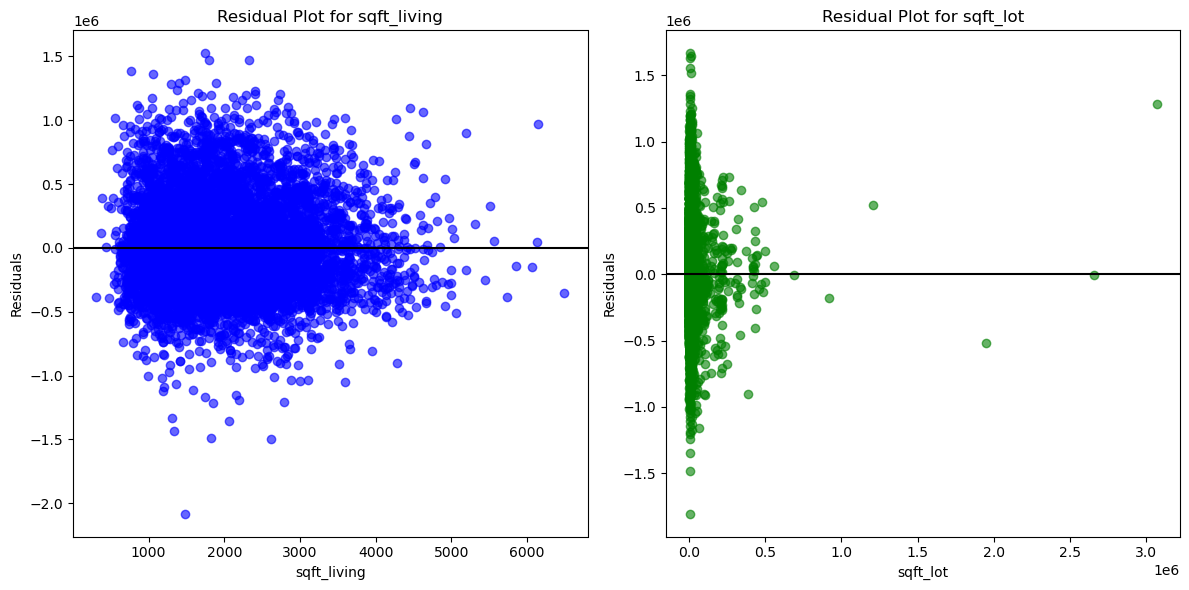

In [17]:
residuals_1 = y1_test - y1_pred

# Choose the two features for the residual plot
feature1 = X1_test['sqft_living']
feature2 = X1_test['sqft_lot']

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the residuals for feature 1
ax1.scatter(feature1, residuals, c='blue', alpha=0.6)
ax1.set_xlabel('sqft_living')
ax1.set_ylabel('Residuals')
ax1.set_title('Residual Plot for sqft_living')
ax1.axhline(y=0, color="black")
# Plot the residuals for feature 2
ax2.scatter(feature2, residuals_1, c='green', alpha=0.6)
ax2.set_xlabel('sqft_lot')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot for sqft_lot')
ax2.axhline(y=0, color="black")
plt.tight_layout()
plt.show()


# 2ND MODEL

Take out 'sqft_lot', add in 'sqft_basement','sqft_garage','sqft_patio'. All are numeric features.

In [18]:
X2 = develop_houses[['sqft_living','sqft_basement','sqft_garage','sqft_patio']]
y = develop_houses['price']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.3)
result_2 = lr.fit(X2_train, y2_train)
rsquared_2 = lr.score(X2_train, y2_train)
print('rsquared:', rsquared_2)
y2_pred = lr.predict(X2_test)
MAE_2 = mean_absolute_error(y2_test, y2_pred)
print('MAE_2:', MAE_2)

rsquared: 0.3256356001176526
MAE_2: 279004.7800090042


In [19]:
# Add data
model_table.loc[2] = ['2nd model', 'Sqft_living, sqft_basement,sqft_garage,sqft_patio', X2.shape[1], round(rsquared_2,3)
                         , MAE_2 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067
2,2nd model,"Sqft_living, sqft_basement,sqft_garage,sqft_patio",4,0.326,279004.780009


2nd model improves by increasing R2 and decreasing the MAE.

In [20]:
results_2_OLS = sm.OLS(y2_train,sm.add_constant(X2_train)).fit()
# results_2_OLS.summary()

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


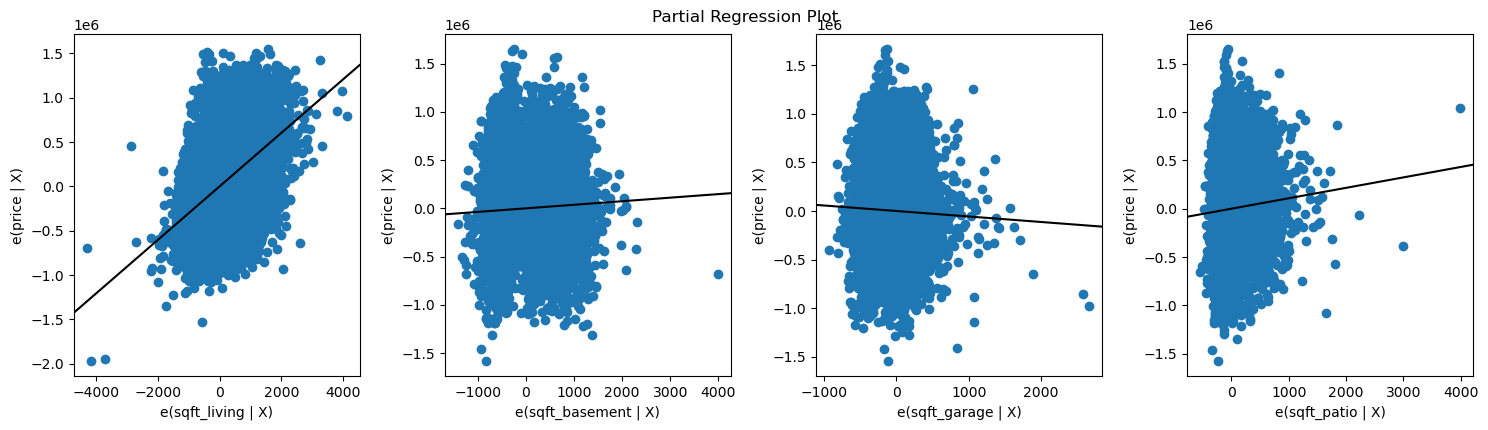

In [21]:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    results_2_OLS,
    exog_idx=list(X2_train.columns.values),
    grid=(2,4),
    fig=fig)
plt.show()

Looking at the regression, 'sqft_garage' likely has negative correlation with price so that it should be taken out. We make a try to take it out and the R2 and MAQ did not have much impact. Even though sqft_basement does not have negative correlation with price but its impact is minimal that can be dropped as well.

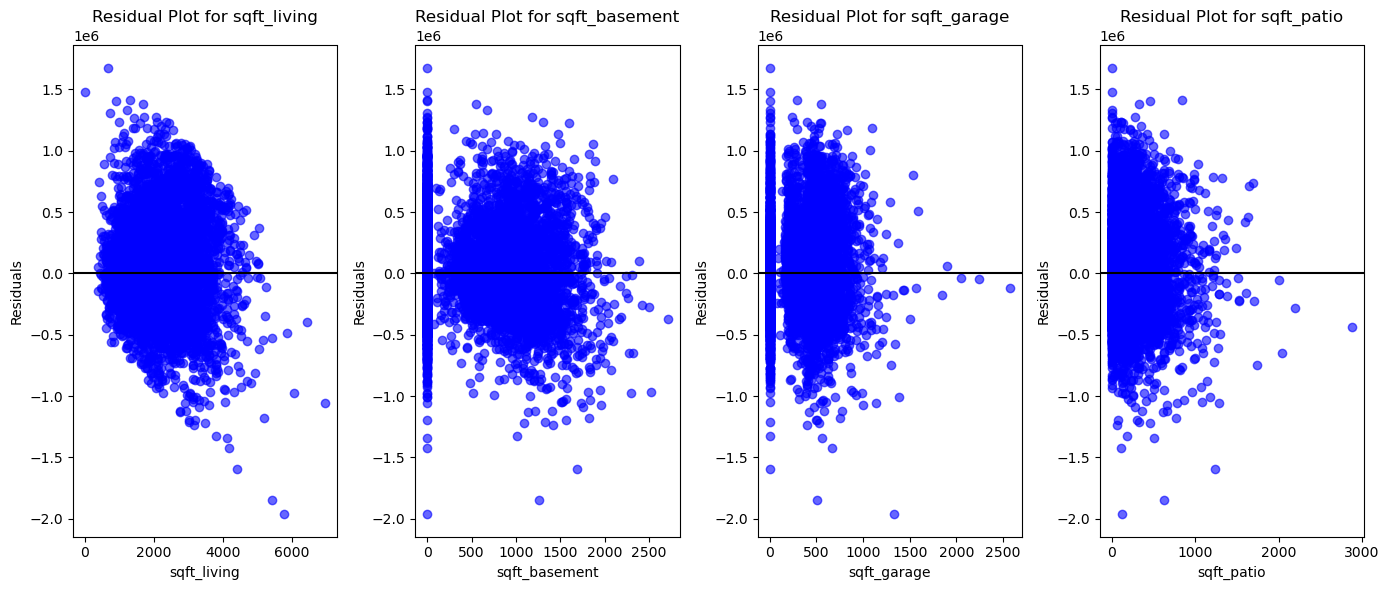

In [22]:
#Calculate the residuals:
residuals_2 = y2_test - y2_pred

# Choose the features for the residual plots
features = ['sqft_living','sqft_basement','sqft_garage','sqft_patio']

# Create the figure and subplots
fig, axes = plt.subplots(1, len(features), figsize=(14, 6))

# Iterate over the features and create the residual plots
for i, feature in enumerate(features):
    ax = axes[i]
    ax.scatter(X2_test[feature], residuals_2, c='blue', alpha=0.6)
    ax.set_xlabel(feature)
    ax.set_ylabel('Residuals')
    ax.set_title('Residual Plot for ' + feature)
    ax.axhline(y=0, color="black")
    
plt.tight_layout()
plt.show()


# 3RD MODEL

Take out 'sqft_garage', 'sqft_basement' and add in 'bedrooms', 'bathrooms'

In [118]:
X3 = develop_houses[['sqft_living','sqft_patio','bedrooms','bathrooms']]
y = develop_houses['price']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.3)
result_3 = lr.fit(X3_train, y3_train)
rsquared_3 = lr.score(X3_train, y3_train)
print('rsquared:', rsquared_3)
y3_pred = lr.predict(X3_test)
MAE_3 = mean_absolute_error(y3_test, y3_pred)
print('MAE_3:', MAE_3)

rsquared: 0.3247703875333262
MAE_3: 281206.10408959416


In [119]:
# Add data for simple linear regression
model_table.loc[3] = ['3rd model', 'sqft_living, sqft_patio + bedrooms, bathrooms', X3.shape[1], round(rsquared_3,3)
                         , MAE_3 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067
2,2nd model,"Sqft_living, sqft_basement,sqft_garage,sqft_patio",4,0.326,279004.780009
3,3rd model,"sqft_living, sqft_patio + bedrooms, bathrooms",4,0.325,281206.104090
4,4th model,"sqft_living, sqft_patio + bathrooms + grade",4,0.375,271277.023296
5,5th model,model4 + age_sold,5,0.428,251323.948652
6,6th model,model5 + view,6,0.434,253231.362014
7,7th model,model5 + condition,6,0.432,251194.184651
8,8th model,model 7 + standadized,6,0.430,251754.850184
9,9th model,model 7 + normalized,6,0.422,251297.464989


In [120]:
results_3_OLS = sm.OLS(y3_train,sm.add_constant(X3_train)).fit()
# results_3_OLS.summary()

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


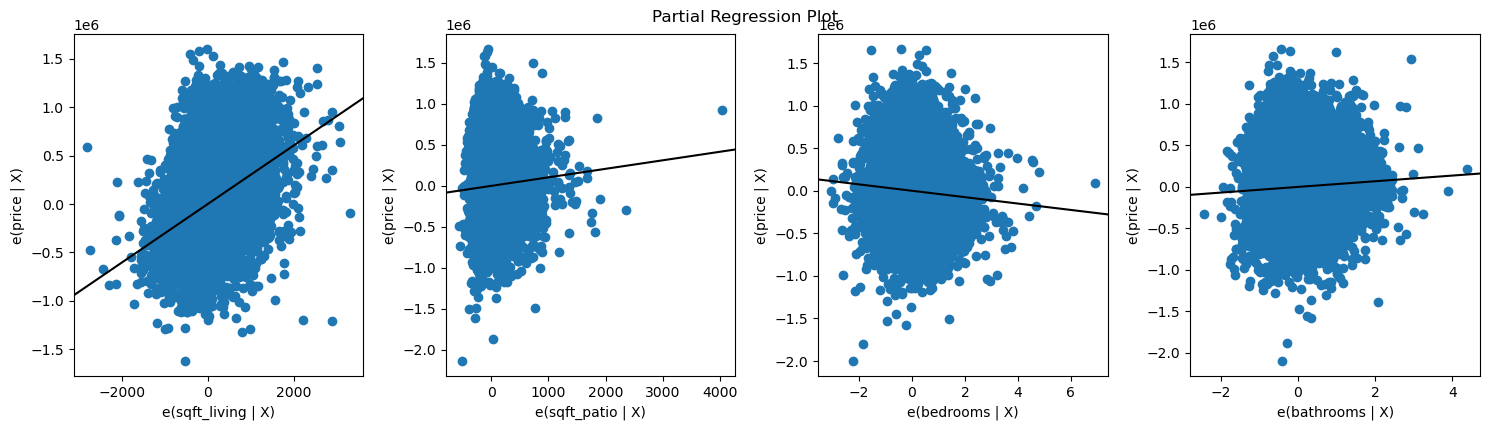

In [121]:
# linear charts:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    results_3_OLS,
    exog_idx=list(X3_train.columns.values),
    grid=(2,4),
    fig=fig)
plt.show()

From the chart we can see that 'bedrooms' is not a good feature to add in the model as it makes negative impact on R2 and MAE. We then can drop 'bedrooms' out of the model.

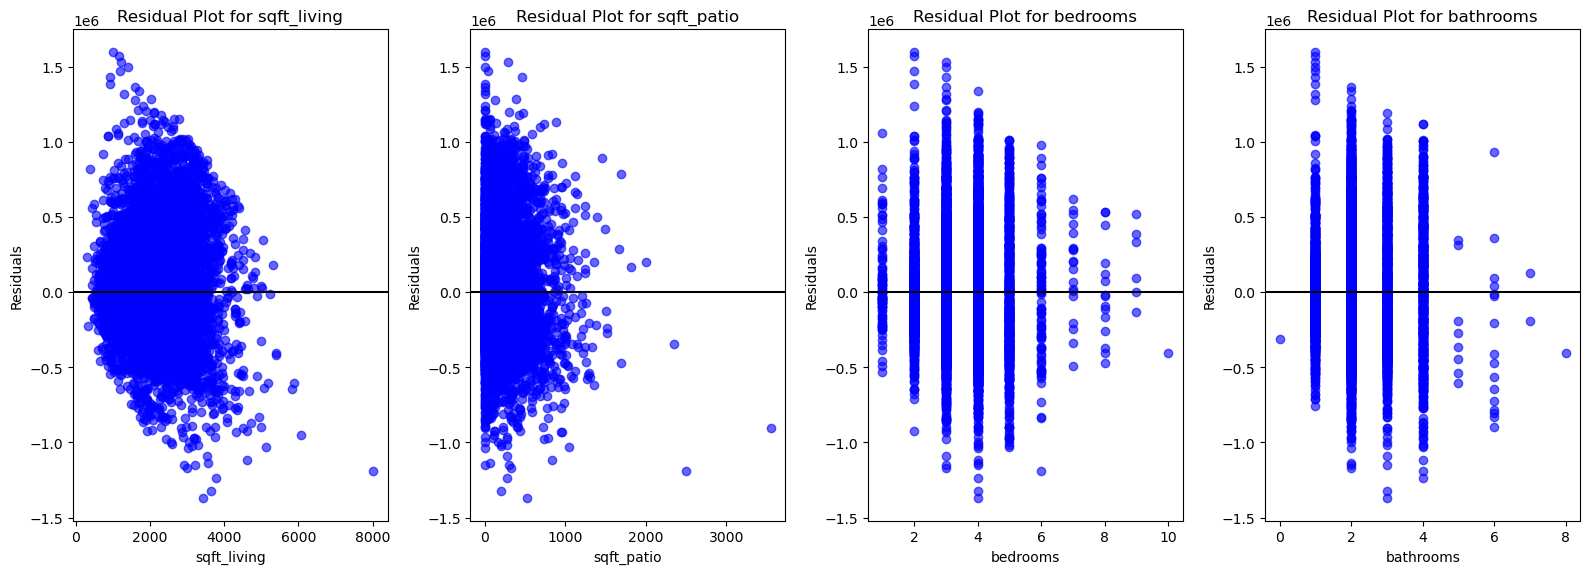

In [122]:
residuals_3 = y3_test - y3_pred

# Choose the features for the residual plots
features = ['sqft_living','sqft_patio','bedrooms','bathrooms']

# Create the figure and subplots
fig, axes = plt.subplots(1, len(features), figsize=(16, 6))

# Iterate over the features and create the residual plots
for i, feature in enumerate(features):
    ax = axes[i]
    ax.scatter(X3_test[feature], residuals_3, c='blue', alpha=0.6)
    ax.set_xlabel(feature)
    ax.set_ylabel('Residuals')
    ax.set_title('Residual Plot for ' + feature)
    ax.axhline(y=0, color="black")
    
plt.tight_layout()
plt.show()


# 4TH MODEL

Add "grade", takeout 'bedrooms'

In [123]:
X4 = develop_houses[['sqft_living','sqft_patio','bathrooms','grade']]
y = develop_houses['price']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size=0.3)
result_4 = lr.fit(X4_train, y4_train)
rsquared_4 = lr.score(X4_train, y4_train)
print('rsquared:', rsquared_4)
y4_pred = lr.predict(X4_test)
MAE_4 = mean_absolute_error(y4_test, y4_pred)
print('MAE_4:', MAE_4)

rsquared: 0.3707553443980941
MAE_4: 270353.1455160645


In [124]:
results_4_OLS = sm.OLS(y4_train,sm.add_constant(X4_train)).fit()
# results_4_OLS.summary()

In [125]:
# Add data:
model_table.loc[4] = ['4th model', 'sqft_living, sqft_patio + bathrooms + grade', X4.shape[1], round(rsquared_4,3)
                          , MAE_4 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067
2,2nd model,"Sqft_living, sqft_basement,sqft_garage,sqft_patio",4,0.326,279004.780009
3,3rd model,"sqft_living, sqft_patio + bedrooms, bathrooms",4,0.325,281206.104090
4,4th model,"sqft_living, sqft_patio + bathrooms + grade",4,0.371,270353.145516
5,5th model,model4 + age_sold,5,0.428,251323.948652
6,6th model,model5 + view,6,0.434,253231.362014
7,7th model,model5 + condition,6,0.432,251194.184651
8,8th model,model 7 + standadized,6,0.430,251754.850184
9,9th model,model 7 + normalized,6,0.422,251297.464989


Clearly seen that 'grade' makes a significant impact on R2 increase and MAE drop.

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


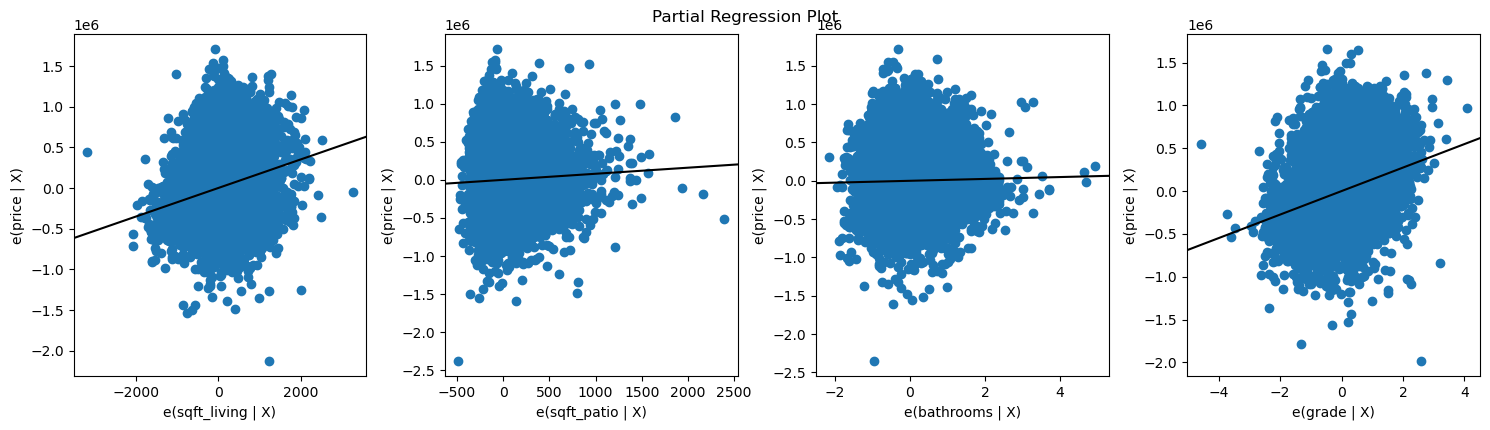

In [126]:
# linear charts:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    results_4_OLS,
    exog_idx=list(X4_train.columns.values),
    grid=(2,4),
    fig=fig)
plt.show()

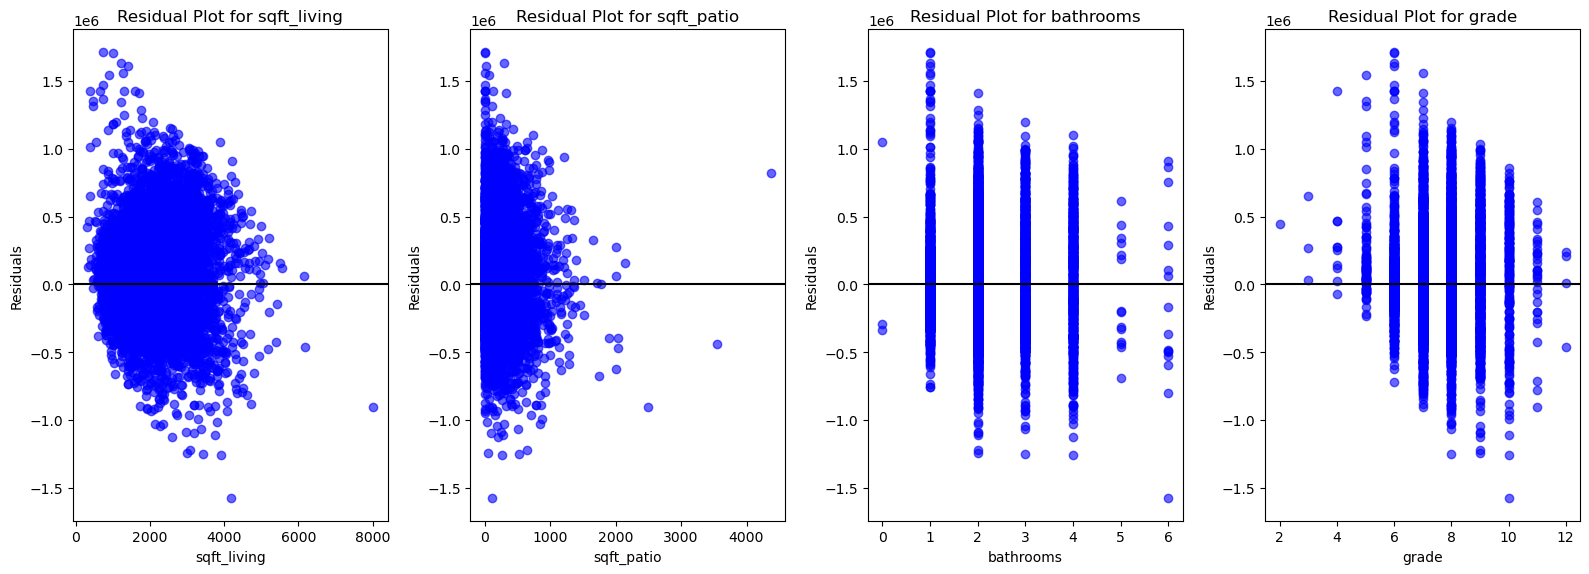

In [127]:
residuals_4 = y4_test - y4_pred

# Choose the features for the residual plots
features = ['sqft_living','sqft_patio','bathrooms','grade']

# Create the figure and subplots
fig, axes = plt.subplots(1, len(features), figsize=(16, 6))

# Iterate over the features and create the residual plots
for i, feature in enumerate(features):
    ax = axes[i]
    ax.scatter(X4_test[feature], residuals_4, c='blue', alpha=0.6)
    ax.set_xlabel(feature)
    ax.set_ylabel('Residuals')
    ax.set_title('Residual Plot for ' + feature)
    ax.axhline(y=0, color="black")
    
plt.tight_layout()
plt.show()


# 5TH MODEL

Add "age_sold", calculated by year_sold minus by year_built.

In [128]:
X5 = develop_houses[['sqft_living','sqft_patio','bathrooms','grade','age_sold']]
y = develop_houses['price']
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y, test_size=0.3)
result_5 = lr.fit(X5_train, y5_train)
rsquared_5 = lr.score(X5_train, y5_train)
print('rsquared:', rsquared_5)
y5_pred = lr.predict(X5_test)
MAE_5 = mean_absolute_error(y5_test, y5_pred)
print('MAE_5:', MAE_5)

rsquared: 0.42500959722424314
MAE_5: 252444.19663132145


In [129]:
# Add data:
model_table.loc[5] = ['5th model', 'model4 + age_sold', X5.shape[1], round(rsquared_5,3)
                          , MAE_5 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067
2,2nd model,"Sqft_living, sqft_basement,sqft_garage,sqft_patio",4,0.326,279004.780009
3,3rd model,"sqft_living, sqft_patio + bedrooms, bathrooms",4,0.325,281206.104090
4,4th model,"sqft_living, sqft_patio + bathrooms + grade",4,0.371,270353.145516
5,5th model,model4 + age_sold,5,0.425,252444.196631
6,6th model,model5 + view,6,0.434,253231.362014
7,7th model,model5 + condition,6,0.432,251194.184651
8,8th model,model 7 + standadized,6,0.430,251754.850184
9,9th model,model 7 + normalized,6,0.422,251297.464989


R2 increases from 0.373 to 0.424 while MAE dropped ~20K USD.

In [130]:
results_5_OLS = sm.OLS(y5_train,sm.add_constant(X5_train)).fit()
# results_5_OLS.summary()

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


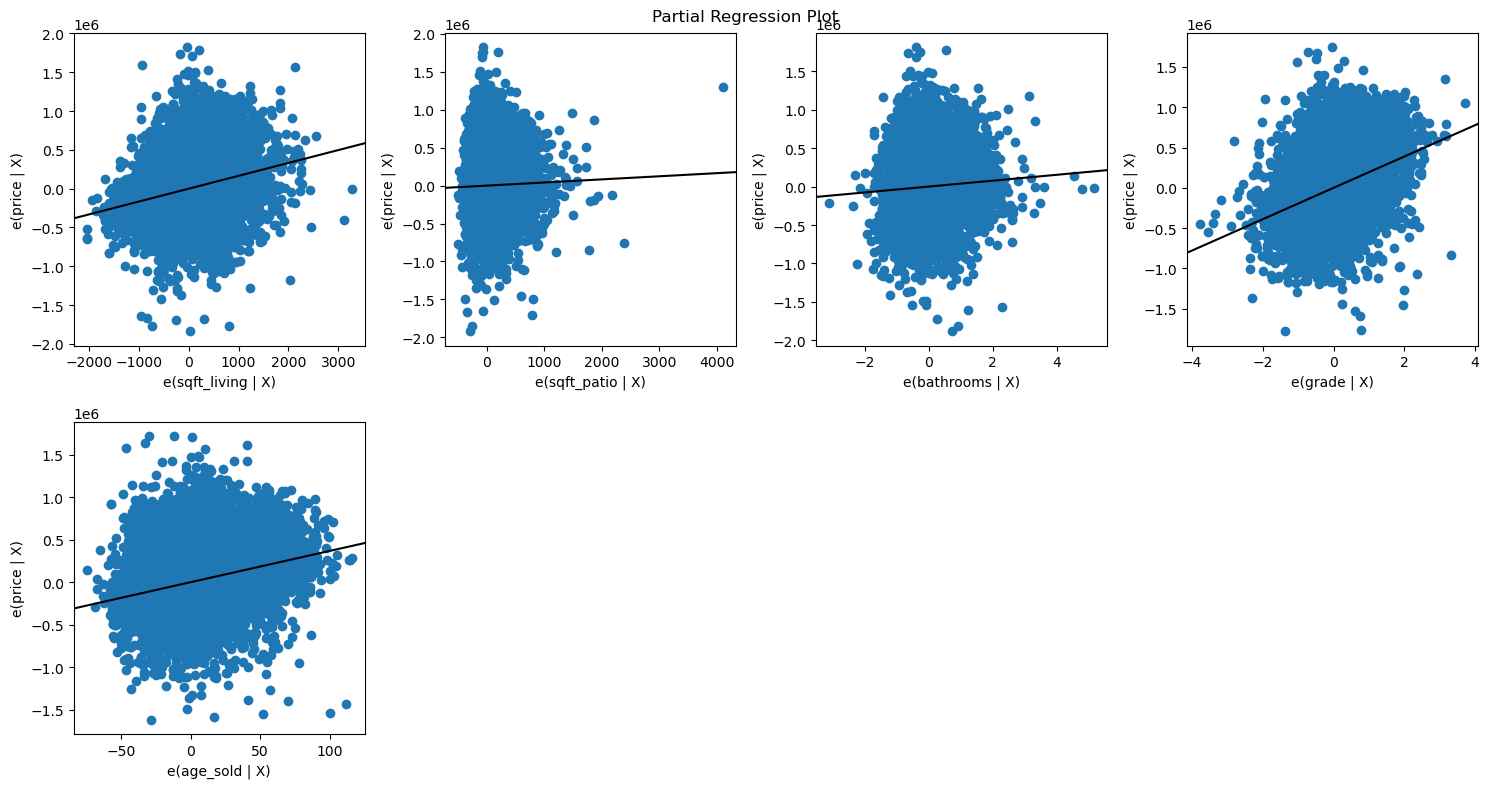

In [131]:
# linear charts:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    results_5_OLS,
    exog_idx=list(X5_train.columns.values),
    grid=(2,4),
    fig=fig)
plt.show()

All of the features are in positive correlation with price.

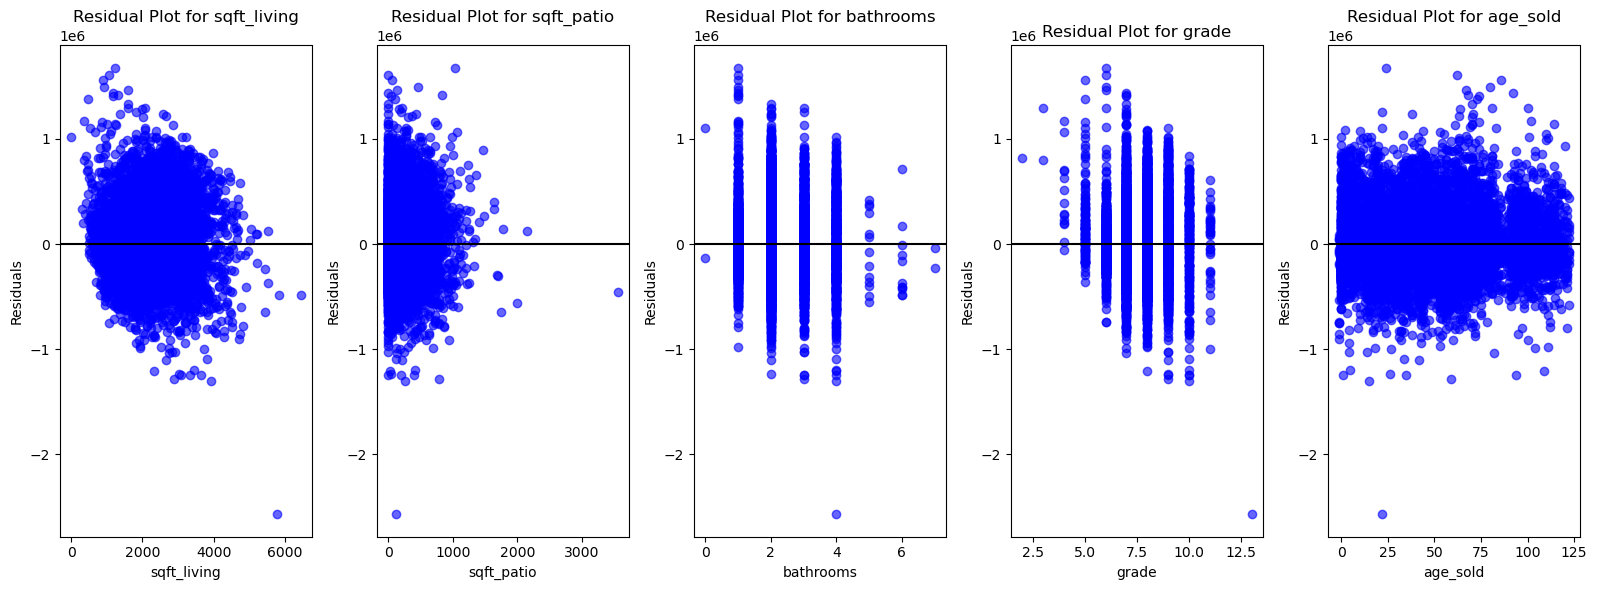

In [132]:
residuals_5 = y5_test - y5_pred

# Choose the features for the residual plots
features = ['sqft_living','sqft_patio','bathrooms','grade','age_sold']

# Create the figure and subplots
fig, axes = plt.subplots(1, len(features), figsize=(16, 6))

# Iterate over the features and create the residual plots
for i, feature in enumerate(features):
    ax = axes[i]
    ax.scatter(X5_test[feature], residuals_5, c='blue', alpha=0.6)
    ax.set_xlabel(feature)
    ax.set_ylabel('Residuals')
    ax.set_title('Residual Plot for ' + feature)
    ax.axhline(y=0, color="black")
    
plt.tight_layout()
plt.show()

# 6TH MODEL

Adding "view", which previously was a categorical feature, then transformed to a ordinal feature. 

In [39]:
develop_houses.view.value_counts()

0    24238
2     1551
3      599
1      171
4      150
Name: view, dtype: int64

In [40]:
X6 = develop_houses[['sqft_living','sqft_patio','bathrooms','grade','age_sold','view']]
y = develop_houses['price']
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y, test_size=0.3)
result_6 = lr.fit(X6_train, y6_train)
rsquared_6 = lr.score(X6_train, y6_train)
print('rsquared:', rsquared_6)
y6_pred = lr.predict(X6_test)
MAE_6 = mean_absolute_error(y6_test, y6_pred)
print('MAE_6:', MAE_6)

rsquared: 0.4343339618987274
MAE_6: 253231.36201441512


In [41]:
model_table.loc[6] = ['6th model', 'model5 + view', X6.shape[1], round(rsquared_6,3)
                          , MAE_6 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067
2,2nd model,"Sqft_living, sqft_basement,sqft_garage,sqft_patio",4,0.326,279004.780009
3,3rd model,"sqft_living, sqft_patio + bedrooms, bathrooms",4,0.329,282635.705513
4,4th model,"sqft_living, sqft_patio + bathrooms + grade",4,0.375,271277.023296
5,5th model,model4 + age_sold,5,0.428,251323.948652
6,6th model,model5 + view,6,0.434,253231.362014


R2 slightly increased after adding view whilst MAE also increased, meaning that 'view' might not be a good feature to add in.

In [42]:
results_6_OLS = sm.OLS(y6_train,sm.add_constant(X6_train)).fit()
# results_6_OLS.summary()

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


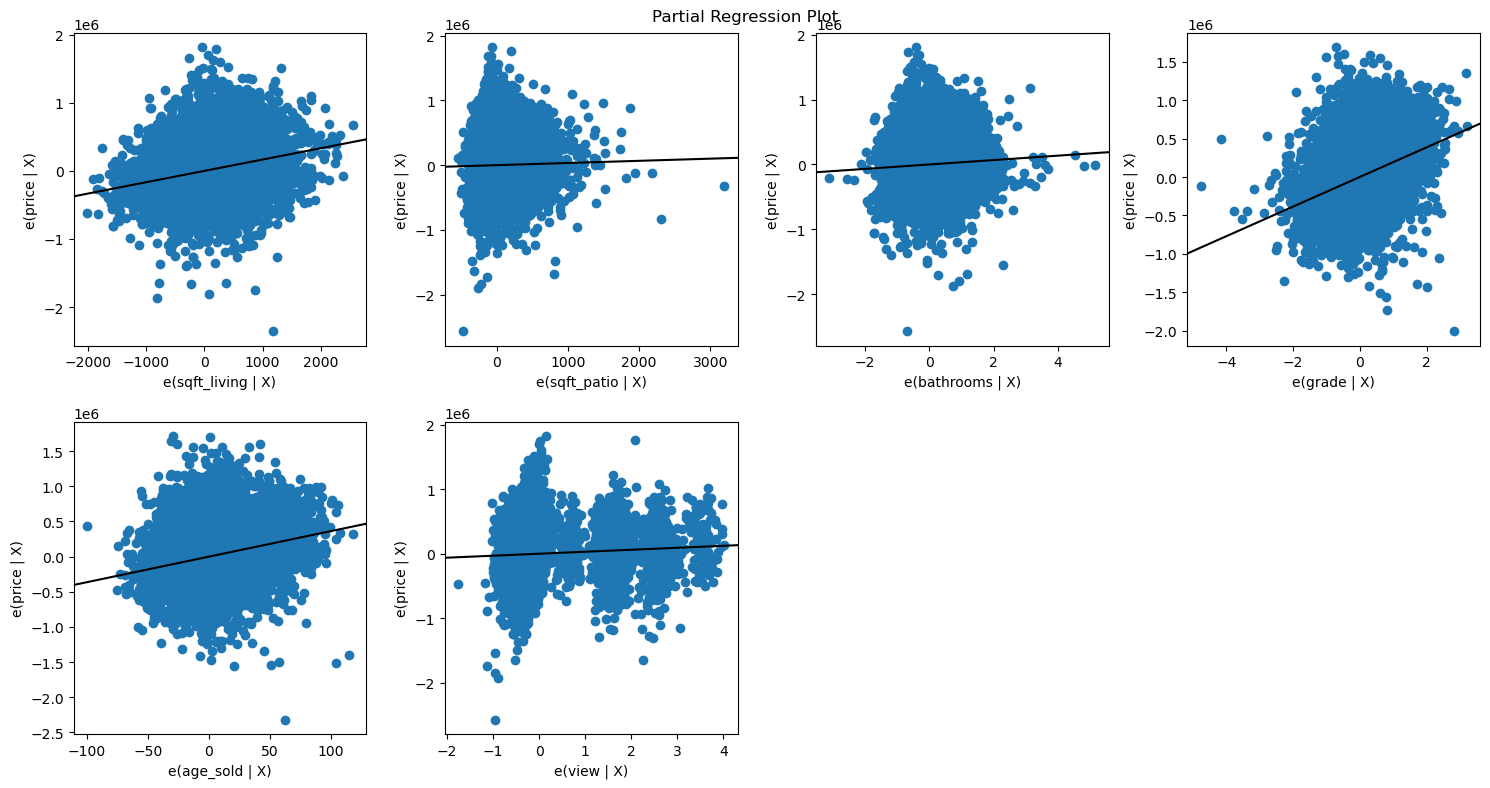

In [43]:
# linear charts:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    results_6_OLS,
    exog_idx=list(X6_train.columns.values),
    grid=(2,4),
    fig=fig)
plt.show()

# 7TH MODEL

Add "condition", another categorical feature, turn it into ordinal feature as well.

In [44]:
X7 = develop_houses[['sqft_living','sqft_patio','bathrooms','grade','age_sold','condition']]
y = develop_houses['price']
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y, test_size=0.3)
result_7 = lr.fit(X7_train, y7_train)
rsquared_7 = lr.score(X7_train, y7_train)
print('rsquared:', rsquared_7)
y7_pred = lr.predict(X7_test)
MAE_7 = mean_absolute_error(y7_test, y7_pred)
print('MAE_7:', MAE_7)


rsquared: 0.43208003370956516
MAE_7: 251194.1846512173


In [45]:
model_table.loc[7] = ['7th model', 'model5 + condition', X7.shape[1], round(rsquared_7,3)
                          , MAE_7 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067
2,2nd model,"Sqft_living, sqft_basement,sqft_garage,sqft_patio",4,0.326,279004.780009
3,3rd model,"sqft_living, sqft_patio + bedrooms, bathrooms",4,0.329,282635.705513
4,4th model,"sqft_living, sqft_patio + bathrooms + grade",4,0.375,271277.023296
5,5th model,model4 + age_sold,5,0.428,251323.948652
6,6th model,model5 + view,6,0.434,253231.362014
7,7th model,model5 + condition,6,0.432,251194.184651


R2 increased by 0.6 while MAE dropped ~ $410. We can consider to keep this feature in the model

In [46]:
results_7_OLS = sm.OLS(y7_train,sm.add_constant(X7_train)).fit()
# results_7_OLS.summary()

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


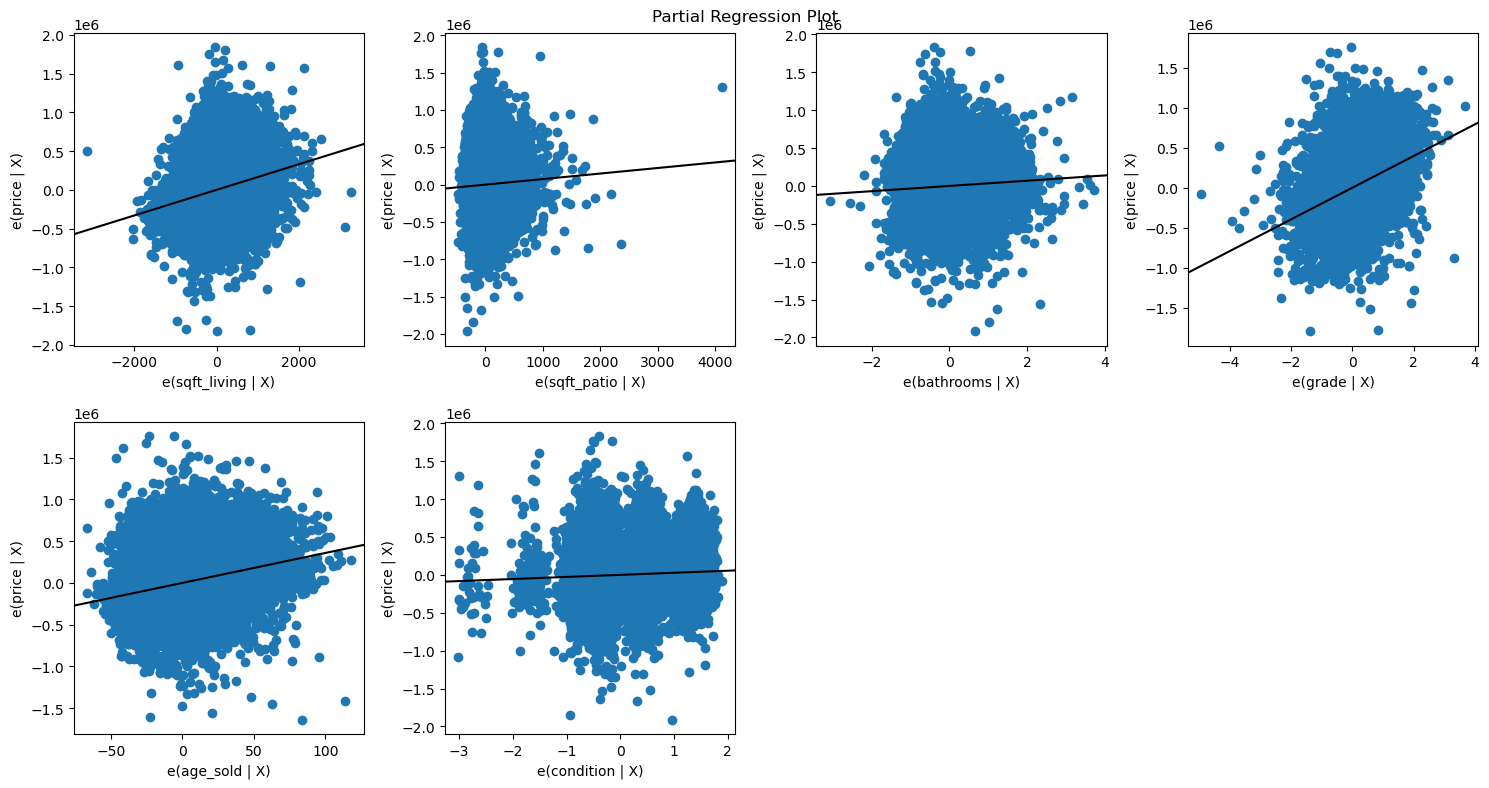

In [47]:
# linear charts:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    results_7_OLS,
    exog_idx=list(X7_train.columns.values),
    grid=(2,4),
    fig=fig)
plt.show()

# 8TH MODEL

Take model 7, which includes 6 numeric features to standardize them.

In [133]:
from sklearn.preprocessing import StandardScaler

In [134]:
X8 = develop_houses[['sqft_living','sqft_patio','bathrooms','grade','age_sold','condition']]
y = develop_houses['price']
X8_train, X8_test, y8_train, y8_test = train_test_split(X8, y, test_size=0.3)

In [135]:
X8.head()

,sqft_living,sqft_patio,bathrooms,grade,age_sold,condition
0,1180,40,1.0,7,53,4
1,1830,90,2.0,7,72,3
2,2170,60,2.0,7,49,3
3,1400,330,2.0,6,51,4
4,1520,200,2.0,8,40,3


In [136]:
ss = StandardScaler()
ss.fit(X8_train)
X8_standardized_train = ss.transform(X8_train)
X8_standardized_test = ss.transform(X8_test)

In [137]:
X8_standardized_train

array([[-0.42085788, -0.88472196, -0.1953518 , -0.50789322,  0.40479709,
         2.1186472 ],
       [-1.20246707,  0.31810451, -0.1953518 ,  0.49438371, -1.49828617,
        -0.69958319],
       [-1.13943407, -0.88472196, -0.1953518 , -0.50789322,  0.4682332 ,
        -0.69958319],
       ...,
       [-0.37043148, -0.61742719, -0.1953518 ,  0.49438371,  1.92726369,
        -0.69958319],
       [ 0.52463711,  0.00626061, -0.1953518 , -0.50789322,  0.18277071,
        -0.69958319],
       [ 1.6088047 , -0.57287806,  2.23465299,  0.49438371, -1.46656811,
        -0.69958319]])

In [138]:
X8_standardized_train.mean(axis = 0)

array([-1.52020269e-17,  7.60101343e-19,  2.38291771e-16, -3.29123882e-16,
        4.71262833e-17, -1.68172422e-16])

In [139]:
X8_standardized_train.shape

(18696, 6)

In [140]:
X8_standardized_train.std(axis = 0)

array([1., 1., 1., 1., 1., 1.])

In [141]:

result_8 = lr.fit(X8_standardized_train, y8_train)
rsquared_8 = lr.score(X8_standardized_train, y8_train)
rsquared_8

0.43032079543347224

In [142]:
y8_pred = lr.predict(X8_standardized_test)
MAE_8 = mean_absolute_error(y8_pred, y8_test)
MAE_8

249702.8448302302

In [143]:
model_table.loc[8] = ['8th model', 'model 7 + standadized', X8.shape[1], round(rsquared_8,3)
                          , MAE_8 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067
2,2nd model,"Sqft_living, sqft_basement,sqft_garage,sqft_patio",4,0.326,279004.780009
3,3rd model,"sqft_living, sqft_patio + bedrooms, bathrooms",4,0.325,281206.104090
4,4th model,"sqft_living, sqft_patio + bathrooms + grade",4,0.371,270353.145516
5,5th model,model4 + age_sold,5,0.425,252444.196631
6,6th model,model5 + view,6,0.434,253231.362014
7,7th model,model5 + condition,6,0.432,251194.184651
8,8th model,model 7 + standadized,6,0.430,249702.844830
9,9th model,model 7 + normalized,6,0.422,251297.464989


Standardizing model 7 to compare R2 & MAE with model 7. Results show that the variance is minimal.

# 9TH MODEL

Normalizing model 7 with MinMaxScaler

In [144]:
from sklearn.preprocessing import MinMaxScaler

In [145]:
X9 = develop_houses[['sqft_living','sqft_patio','bathrooms','grade','age_sold','condition']]
y = develop_houses['price']
X9_train, X9_test, y9_train, y9_test = train_test_split(X9, y, test_size=0.3)

In [146]:
mn = MinMaxScaler()
mn.fit(X9_train)
X9_normalized_train = mn.transform(X9_train)
X9_normalized_test = mn.transform(X9_test)

In [147]:
X9_normalized_train.mean(axis = 0)

array([0.25057226, 0.04540716, 0.27017811, 0.50106002, 0.39942416,
       0.62308783])

In [148]:
result_9 = lr.fit(X9_normalized_train, y9_train)
rsquared_9 = lr.score(X9_normalized_train, y9_train)
rsquared_9

0.42755389842744973

In [149]:
y9_pred = lr.predict(X9_normalized_test)
MAE_9 = mean_absolute_error(y9_pred, y9_test)
MAE_9

248653.75222406205

In [150]:
model_table.loc[9] = ['9th model', 'model 7 + normalized', X9.shape[1], round(rsquared_9,3)
                          , MAE_9 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067
2,2nd model,"Sqft_living, sqft_basement,sqft_garage,sqft_patio",4,0.326,279004.780009
3,3rd model,"sqft_living, sqft_patio + bedrooms, bathrooms",4,0.325,281206.104090
4,4th model,"sqft_living, sqft_patio + bathrooms + grade",4,0.371,270353.145516
5,5th model,model4 + age_sold,5,0.425,252444.196631
6,6th model,model5 + view,6,0.434,253231.362014
7,7th model,model5 + condition,6,0.432,251194.184651
8,8th model,model 7 + standadized,6,0.430,249702.844830
9,9th model,model 7 + normalized,6,0.428,248653.752224


Again, the variance between normalized model 7 with model 7 is minimal.

# 10TH MODEL

Add "greenbelt"

In [151]:
develop_houses.greenbelt.value_counts()

NO     26044
YES      665
Name: greenbelt, dtype: int64

In [152]:
x10_multi = develop_houses[['sqft_living','sqft_patio','bathrooms','grade','age_sold','condition','greenbelt']]
y = develop_houses['price']
X10 = pd.get_dummies(x10_multi, columns =['greenbelt'],drop_first = True)
X10 = X10.apply(lambda x: x.astype(int))
X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y, test_size=0.3)
result_10 = lr.fit(X10_train, y10_train)
rsquared_10 = lr.score(X10_train, y10_train)
print('rsquared:', rsquared_10)
y10_pred = lr.predict(X10_test)
MAE_10 = mean_absolute_error(y10_test, y10_pred)
print('MAE_10:', MAE_10)

rsquared: 0.42755095762414863
MAE_10: 248204.2231482466


In [153]:
model_table.loc[10] = ['10th model', 'model 7 + greenbelt', X10.shape[1], round(rsquared_10,3)
                          , MAE_10 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067
2,2nd model,"Sqft_living, sqft_basement,sqft_garage,sqft_patio",4,0.326,279004.780009
3,3rd model,"sqft_living, sqft_patio + bedrooms, bathrooms",4,0.325,281206.104090
4,4th model,"sqft_living, sqft_patio + bathrooms + grade",4,0.371,270353.145516
5,5th model,model4 + age_sold,5,0.425,252444.196631
6,6th model,model5 + view,6,0.434,253231.362014
7,7th model,model5 + condition,6,0.432,251194.184651
8,8th model,model 7 + standadized,6,0.430,249702.844830
9,9th model,model 7 + normalized,6,0.428,248653.752224


Both R2 and MAE slightly increased, however, comparing with model 7, we should not add this feature into the model.

In [154]:
results_10_OLS = sm.OLS(y10_train,sm.add_constant(X10_train)).fit()
# results_10_OLS.summary()

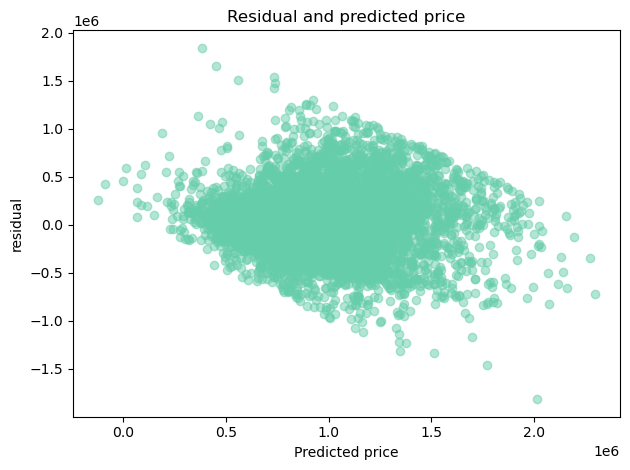

In [155]:
residuals_10 = y10_test - y10_pred
fig, ax = plt.subplots()
ax.scatter(y10_pred, residuals_10, color="mediumaquamarine", alpha=0.5)
ax.set_xlabel('Predicted price')
ax.set_ylabel('residual')
ax.set_title('Residual and predicted price')
plt.tight_layout()
plt.tight_layout()
plt.show()

# 11TH MODEL

Add "nuisance"

In [156]:
x11_multi = develop_houses[['sqft_living','sqft_patio','bathrooms','grade','age_sold','condition','nuisance']]
y = develop_houses['price']
X11 = pd.get_dummies(x11_multi, columns =['nuisance'],drop_first = True)
# X11['nuisance_YES'].value_counts()
X11 = X11.apply(lambda x: x.astype(int))
X11_train, X11_test, y11_train, y11_test = train_test_split(X11, y, test_size=0.3)
result_11 = lr.fit(X11_train, y11_train)
rsquared_11 = lr.score(X11_train, y11_train)
print('rsquared:', rsquared_11)
y11_pred = lr.predict(X11_test)
MAE_11 = mean_absolute_error(y11_test, y11_pred)
print('MAE_11:', MAE_11)

rsquared: 0.4256035195696646
MAE_11: 251413.4389575252


In [157]:
model_table.loc[11] = ['11th model', 'model 7 + nuisance', X11.shape[1], round(rsquared_11,3)
                          , MAE_11 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067
2,2nd model,"Sqft_living, sqft_basement,sqft_garage,sqft_patio",4,0.326,279004.780009
3,3rd model,"sqft_living, sqft_patio + bedrooms, bathrooms",4,0.325,281206.104090
4,4th model,"sqft_living, sqft_patio + bathrooms + grade",4,0.371,270353.145516
5,5th model,model4 + age_sold,5,0.425,252444.196631
6,6th model,model5 + view,6,0.434,253231.362014
7,7th model,model5 + condition,6,0.432,251194.184651
8,8th model,model 7 + standadized,6,0.430,249702.844830
9,9th model,model 7 + normalized,6,0.428,248653.752224


Comparing with model 7, 'Nuisance' made R2 increase and MAE drop so that we should drop it.

In [158]:
results_11_OLS = sm.OLS(y11_train,sm.add_constant(X11_train)).fit()
# results_10_OLS.summary()

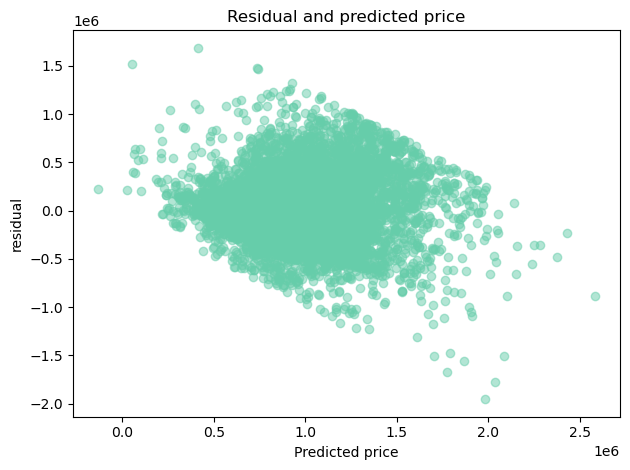

In [159]:
residuals_11 = y11_test - y11_pred
fig, ax = plt.subplots()
ax.scatter(y11_pred, residuals_11, color="mediumaquamarine", alpha=0.5)
ax.set_xlabel('Predicted price')
ax.set_ylabel('residual')
ax.set_title('Residual and predicted price')
plt.tight_layout()
plt.show()

# 12TH MODEL

Add "renovated", which represents as boolean value, True means used to be renovated while False means not yet renovated

In [160]:
develop_houses.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zipcode,city,sold_year,sold_month,age_sold,renovated,price_group
0,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,0,4,7,1180,0,0,40,1969,0,47.461975,-122.19052,98055,Renton,2022,5,53,False,500K-1M


In [161]:
develop_houses.renovated.value_counts()

False    25620
True      1089
Name: renovated, dtype: int64

In [162]:
x12_multi = develop_houses[['sqft_living','sqft_patio','bathrooms','grade','age_sold','renovated']]
y = develop_houses['price']
X12 = pd.get_dummies(x12_multi, columns =['renovated'],drop_first = True)

X12 = X12.apply(lambda x: x.astype(int))
X12_train, X12_test, y12_train, y12_test = train_test_split(X12, y, test_size=0.3)
result_12 = lr.fit(X12_train, y12_train)
rsquared_12 = lr.score(X12_train, y12_train)

print('rsquared:', rsquared_12)
y12_pred = lr.predict(X12_test)
MAE_12 = mean_absolute_error(y12_test, y12_pred)
print('MAE_12:', MAE_12)
result_12.coef_

rsquared: 0.4274709928416649
MAE_12: 249246.68898143107


array([ 1.64903855e+02,  7.00723370e+01,  3.65134248e+04,  1.97592147e+05,
        3.78385014e+03, -6.93543656e+03])

In [163]:
model_table.loc[12] = ['12th model', 'model 7 + renovated', X12.shape[1], round(rsquared_12,3)
                          , MAE_12 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067
2,2nd model,"Sqft_living, sqft_basement,sqft_garage,sqft_patio",4,0.326,279004.780009
3,3rd model,"sqft_living, sqft_patio + bedrooms, bathrooms",4,0.325,281206.104090
4,4th model,"sqft_living, sqft_patio + bathrooms + grade",4,0.371,270353.145516
5,5th model,model4 + age_sold,5,0.425,252444.196631
6,6th model,model5 + view,6,0.434,253231.362014
7,7th model,model5 + condition,6,0.432,251194.184651
8,8th model,model 7 + standadized,6,0.430,249702.844830
9,9th model,model 7 + normalized,6,0.428,248653.752224


Adding "greenbelt feature" does not increase R2 or decrease MAE comparing with model 7, so that we should not include "greenbelt" into the model

# 13TH MODEL

Adding categorical zipcode 'zipcode' then do OneHotCoding.

In [164]:
x13_multi = develop_houses[['sqft_living','sqft_patio','bathrooms','grade','age_sold','zipcode','condition']]
y = develop_houses['price']
X13 = pd.get_dummies(x13_multi, columns =['zipcode'],drop_first = True)
X13 = X13.apply(lambda x: x.astype(int))
X13_train, X13_test, y13_train, y13_test = train_test_split(X13, y, test_size=0.3)
result_13 = lr.fit(X13_train, y13_train)
rsquared_13 = lr.score(X13_train, y13_train)
print('rsquared:', rsquared_13)
y13_pred = lr.predict(X13_test)
MAE_13 = mean_absolute_error(y13_test, y13_pred)
print('MAE_13:', MAE_13)

rsquared: 0.6945151120229347
MAE_13: 170786.17387036845


In [165]:
model_table.loc[13] = ['13th model', 'model 7 + zipcode', x13_multi.shape[1], round(rsquared_13,3)
                          , MAE_13 ]

# View our evaluation table
model_table

,Model,Description,Num Features,R-squared,MAE
0,Baseline Linear Regression,Sqft_living,1,0.319,281422.778000
1,1st model,"Sqft_living, sqft_lot",2,0.315,282754.421067
2,2nd model,"Sqft_living, sqft_basement,sqft_garage,sqft_patio",4,0.326,279004.780009
3,3rd model,"sqft_living, sqft_patio + bedrooms, bathrooms",4,0.325,281206.104090
4,4th model,"sqft_living, sqft_patio + bathrooms + grade",4,0.371,270353.145516
5,5th model,model4 + age_sold,5,0.425,252444.196631
6,6th model,model5 + view,6,0.434,253231.362014
7,7th model,model5 + condition,6,0.432,251194.184651
8,8th model,model 7 + standadized,6,0.430,249702.844830
9,9th model,model 7 + normalized,6,0.428,248653.752224


R2 soared to nearly 70% while MAE plunged to 174k. This is the best model we have had so far and we can considered this as the final model.

In [166]:
results_13_OLS = sm.OLS(y13_train,sm.add_constant(X13_train)).fit()
results_13_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     564.4
Date:                Fri, 02 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:48:38   Log-Likelihood:            -2.5837e+05
No. Observations:               18696   AIC:                         5.169e+05
Df Residuals:                   18620   BIC:                         5.175e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.316e+05   2.48e+04    -29.552      0.000    -7.8e+05   -6.83e+05
sqft_living     212.8859      3.812     55.853      0.000     205.415     220.357
sqft_patio       53.1015      8.686      6.113      0.000      36.076      70.127
bathrooms      5619.3770   3063.116      1.835      0.067    -384.610    1.16e+04
grade          9.479e+04   2896.589     32.724      0.000    8.91e+04       1e+05
age_sold       1144.5583     81.844     13.985      0.000     984.136    1304.981
condition      4.368e+04   2731.770     15.991      0.000    3.83e+04     4.9e+04
zipcode_98002  -954.6751   1.96e+04     -0.049      0.961   -3.94e+04    3.75e+04
zipcode_98003 -3.807e+04   1.83e+04     -2.080      0.038   -7.39e+04   -2190.278
zipcode_98004  1.131e+06   3.23e+04     34.951      0.000    1.07e+06    1.19e+06
zipcode_98005   7.95e+05    2.9e+04     27.427      0.000    7.38e+05    8.52e+05
zipcode_98006  6.692e+05   1.89e+04     35.333      0.000    6.32e+05    7.06e+05
zipcode_98007  5.797e+05   2.88e+04     20.157      0.000    5.23e+05    6.36e+05
zipcode_98008  6.511e+05   1.95e+04     33.472      0.000    6.13e+05    6.89e+05
zipcode_98010  4.834e+04   2.06e+04      2.343      0.019    7895.531    8.88e+04
zipcode_98011  4.866e+05    2.2e+04     22.113      0.000    4.43e+05     5.3e+05
zipcode_98014  2.274e+05    2.7e+04      8.420      0.000    1.74e+05     2.8e+05
zipcode_98019  2.793e+05   2.19e+04     12.764      0.000    2.36e+05    3.22e+05
zipcode_98022  3.102e+04   1.81e+04      1.711      0.087   -4509.526    6.66e+04
zipcode_98023 -5.317e+04   1.63e+04     -3.266      0.001   -8.51e+04   -2.13e+04
zipcode_98024  4.007e+05   3.23e+04     12.394      0.000    3.37e+05    4.64e+05
zipcode_98027  4.896e+05   1.96e+04     24.963      0.000    4.51e+05    5.28e+05
zipcode_98028  3.684e+05   1.98e+04     18.603      0.000     3.3e+05    4.07e+05
zipcode_98029   6.39e+05   2.14e+04     29.895      0.000    5.97e+05    6.81e+05
zipcode_98030  8502.0931   1.92e+04      0.444      0.657   -2.91e+04    4.61e+04
zipcode_98031  2.099e+04   1.73e+04      1.214      0.225   -1.29e+04    5.49e+04
zipcode_98032  2.686e+04   2.51e+04      1.070      0.285   -2.24e+04    7.61e+04
zipcode_98033  8.324e+05   1.89e+04     44.128      0.000    7.95e+05    8.69e+05
zipcode_98034  5.354e+05   1.65e+04     32.497      0.000    5.03e+05    5.68e+05
zipcode_98038  1.325e+05   1.57e+04      8.437      0.000    1.02e+05    1.63e+05
zipcode_98040  8.645e+05   2.73e+04     31.650      0.000    8.11e+05    9.18e+05
zipcode_98042  2.338e+04   1.52e+04      1.542      0.123   -6340.913    5.31e+04
zipcode_98045  2.763e+05   1.85e+04     14.926      0.000     2.4e+05    3.13e+05
zipcode_98052  6.793e+05   1.73e+04     39.277      0.000    6.45e+05    7.13e+05
zipcode_98053  5.776e+05   1.98e+04     29.117   

In [167]:
X13_train.columns

Index(['sqft_living', 'sqft_patio', 'bathrooms', 'grade', 'age_sold',
       'condition', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004',
       'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008',
       'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019',
       'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031',
       'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98057',
       'zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
       'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077',
       'zipcode_98092', 'zipcode_98102', 'zipcode_98103', 'zipcode_98105',
       'zipcode_98106', 'zipcode_98107', 'zipcode_98108', 'zipcode_98109',
       'zipcode_98112', 'zipcode_9

In [168]:
result_13.coef_

array([ 2.12885856e+02,  5.31015440e+01,  5.61937697e+03,  9.47878024e+04,
        1.14455835e+03,  4.36826956e+04, -9.54675109e+02, -3.80685156e+04,
        1.13056183e+06,  7.94979229e+05,  6.69195068e+05,  5.79656962e+05,
        6.51064797e+05,  4.83433397e+04,  4.86615082e+05,  2.27416508e+05,
        2.79338330e+05,  3.10237314e+04, -5.31720203e+04,  4.00665395e+05,
        4.89599734e+05,  3.68424121e+05,  6.39029438e+05,  8.50209309e+03,
        2.09918868e+04,  2.68569993e+04,  8.32367398e+05,  5.35439518e+05,
        1.32473842e+05,  8.64543876e+05,  2.33768948e+04,  2.76313678e+05,
        6.79345299e+05,  5.77617138e+05,  7.19071459e+04,  2.57606500e+05,
        1.23114275e+05,  8.10742423e+04,  2.65910251e+05,  4.25621181e+05,
        2.72836058e+05,  4.92156687e+05,  6.49536646e+05,  7.11187258e+05,
        5.08969449e+05, -1.19180625e+04,  5.78295388e+05,  4.70538947e+05,
        5.15711829e+05,  1.67730953e+05,  4.79286610e+05,  1.81183602e+05,
        6.47338336e+05,  

In [169]:
weight_df = pd.DataFrame(zip(X13_train.columns,result_13.coef_))
weight_df = weight_df.rename(columns={0: 'Feature', 1: 'Weight'}).sort_values(by = "Weight", ascending = False)
weight_df.head(10)

,Feature,Weight
8,zipcode_98004,1.130562e+06
29,zipcode_98040,8.645439e+05
26,zipcode_98033,8.323674e+05
9,zipcode_98005,7.949792e+05
43,zipcode_98075,7.111873e+05
32,zipcode_98052,6.793453e+05
10,zipcode_98006,6.691951e+05
12,zipcode_98008,6.510648e+05
42,zipcode_98074,6.495366e+05
52,zipcode_98109,6.473383e+05


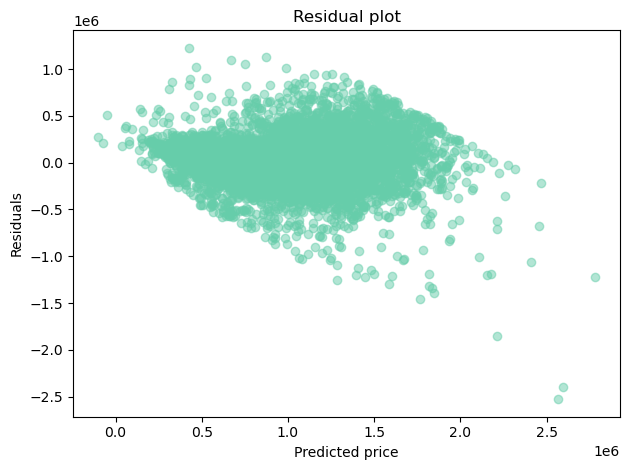

In [170]:
#Residual plot:
residuals_13 = y13_test - y13_pred
fig, ax = plt.subplots()
ax.scatter(y13_pred, residuals_13, color="mediumaquamarine", alpha=0.5)
plt.title('Residual plot')
ax.set_xlabel('Predicted price')
ax.set_ylabel('Residuals')
plt.tight_layout()
plt.show()

Looking at the residuals, the predicted price range less than 1M USD likely is the narrowest.

In [171]:
len(y13_train)

18696

Check normal distribution of residuals

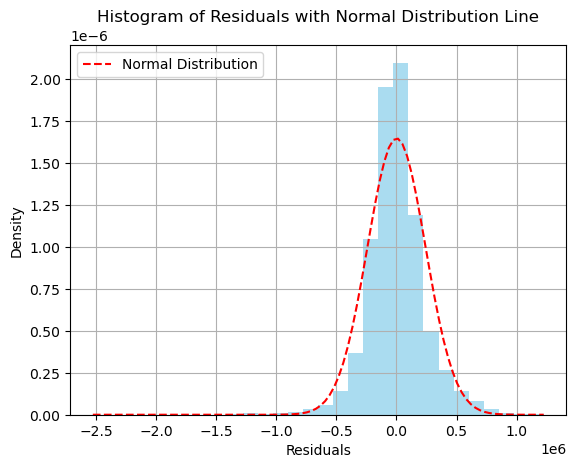

In [172]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Plot the histogram
residuals_13.hist(bins=30, density=True, alpha=0.7, color='skyblue')

# Compute mean and standard deviation of residuals
mean = residuals_13.mean()
std = residuals_13.std()

# Create an array of values to plot the normal distribution line
x = np.linspace(residuals_13.min(), residuals_13.max(), 100)
y = stats.norm.pdf(x, mean, std)

# Plot the normal distribution line
plt.plot(x, y, color='red', linestyle='--', label='Normal Distribution')

# Add labels and legend
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Histogram of Residuals with Normal Distribution Line')
plt.legend()

# Show the plot
plt.show()


After getting the predicted price, combine it into the test data set. Then we will have a dataframe with selling prices and predicted selling prices.

In [173]:
predict_model_13 = pd.concat([X13_test.reset_index(), y13_test.reset_index(), pd.Series(y13_pred, name='predicted_price')], axis=1)

In [90]:
predict_model_13.head()

,index,sqft_living,sqft_patio,bathrooms,grade,age_sold,condition,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98057,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,index,price,predicted_price
0,26625,1400,0,2,7,53,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26625,706000.0,8.058509e+05
1,16414,3720,700,3,8,59,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16414,1800000.0,1.710396e+06
2,2716,2650,160,3,8,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2716,884950.0,7.482627e+05
3,11751,1520,290,1,6,73,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11751,750000.0,7.197501e+05
4,23280,1620,110,2,8,19,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23280,660000.0,6.300143e+05


Create price interval in the dataframe with predicted price, called predict_model_13. Later we will analyze the MAE in different price group.

In [93]:
# Create intervals of housing prices for grouping purposes:
price_bins = [0, 500000, 1000000, 1500000, 2000000, 3000000, 5000000, float('inf')]
price_labels=['<500K', '500K-1M', '1M-1.5M','1.5M-2M','2M-3M', '3M-5M', '>5M']

# Create a new column of price intervals:
predict_model_13['price_group'] = pd.cut(predict_model_13['price'], bins = price_bins, labels = price_labels)

Build a function to get the subset of predict_model_13 following to each price group.

In [94]:
def subset (df,start,end):
    subset_df = df[(df['price']> start) & (df['price']<=end)]
    return subset_df


Build a function to get MAE of the subset of predict_model_13 following to each price group.

In [95]:
def MEA (df):
    from sklearn.metrics import mean_absolute_error
    mea = mean_absolute_error (df['price'],df['predicted_price'])
    return mea


Build a function to get undervalue percentage of houses within the subset of predict_model_13 following to each price group.

In [174]:
def undervalue_per (df):
    undervalued_df = df[df['predicted_price'] > df['price']]
    undervalued_percent = undervalued_df.shape[0]/df.shape[0]
    return undervalued_percent

In [175]:
# From predict_model_13, price < 500K:
predict_model_13_500K = subset (predict_model_13,0,500000)
mea_500K = MEA(predict_model_13_500K)
undervalue_per_500k = undervalue_per(predict_model_13_500K)
undervalue_per_500k

0.6486486486486487

In [176]:
# From predict_model_13, price within 500K-1M:
predict_model_13_500K_1M = subset (predict_model_13,500000,1000000)
mea_500K_1M = MEA(predict_model_13_500K_1M)
undervalue_per_500k_1M = undervalue_per(predict_model_13_500K_1M)
undervalue_per_500k_1M

0.6209751609935602

In [177]:
# From predict_model_13, price within 1M-1.5M
predict_model_13_1M_1M5 = subset (predict_model_13,1000000,1500000)
mea_1M_1M5 = MEA(predict_model_13_1M_1M5)
undervalue_per_1M_1M5 = undervalue_per(predict_model_13_1M_1M5)
undervalue_per_1M_1M5

0.3953871499176277

In [178]:
# From predict_model_13, price within 1.5M-2M
predict_model_13_1M5_2M = subset (predict_model_13,1500000,2000000)
mea_1M5_2M = MEA(predict_model_13_1M5_2M)
undervalue_per_1M5_2M = undervalue_per(predict_model_13_1M5_2M)
undervalue_per_1M5_2M

0.1171875

In [179]:
#From predict_model_13, price >2M
predict_model_13_2M = subset (predict_model_13,2000000,2500000)
mea_2M = MEA(predict_model_13_2M)
undervalue_per_2M = undervalue_per(predict_model_13_2M)
undervalue_per_2M

0.03723404255319149

Combine 3 columns into 1 dataframe:

In [180]:
data = {
    'price_group': ['<500K', '500K-1M', '1M-1M5', '1M5-2M', '>2M'],
    'MAE': [mea_500K,mea_500K_1M,mea_1M_1M5,mea_1M5_2M,mea_2M],
    'Under_value_percent':[undervalue_per_500k,undervalue_per_500k_1M,undervalue_per_1M_1M5,undervalue_per_1M5_2M,undervalue_per_2M]
}

In [181]:
df = pd.DataFrame(data)

In [182]:
df.head()

,price_group,MAE,Under_value_percent
0,<500K,209787.972401,0.648649
1,500K-1M,128747.948469,0.620975
2,1M-1M5,166101.028562,0.395387
3,1M5-2M,300260.252966,0.117188
4,>2M,475276.406907,0.037234


# Conclusion

Model 13 is the final model as it has the highest R2 & lowest MAE.

In [183]:
results_13_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     564.4
Date:                Fri, 02 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:49:34   Log-Likelihood:            -2.5837e+05
No. Observations:               18696   AIC:                         5.169e+05
Df Residuals:                   18620   BIC:                         5.175e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.316e+05   2.48e+04    -29.552      0.000    -7.8e+05   -6.83e+05
sqft_living     212.8859      3.812     55.853      0.000     205.415     220.357
sqft_patio       53.1015      8.686      6.113      0.000      36.076      70.127
bathrooms      5619.3770   3063.116      1.835      0.067    -384.610    1.16e+04
grade          9.479e+04   2896.589     32.724      0.000    8.91e+04       1e+05
age_sold       1144.5583     81.844     13.985      0.000     984.136    1304.981
condition      4.368e+04   2731.770     15.991      0.000    3.83e+04     4.9e+04
zipcode_98002  -954.6751   1.96e+04     -0.049      0.961   -3.94e+04    3.75e+04
zipcode_98003 -3.807e+04   1.83e+04     -2.080      0.038   -7.39e+04   -2190.278
zipcode_98004  1.131e+06   3.23e+04     34.951      0.000    1.07e+06    1.19e+06
zipcode_98005   7.95e+05    2.9e+04     27.427      0.000    7.38e+05    8.52e+05
zipcode_98006  6.692e+05   1.89e+04     35.333      0.000    6.32e+05    7.06e+05
zipcode_98007  5.797e+05   2.88e+04     20.157      0.000    5.23e+05    6.36e+05
zipcode_98008  6.511e+05   1.95e+04     33.472      0.000    6.13e+05    6.89e+05
zipcode_98010  4.834e+04   2.06e+04      2.343      0.019    7895.531    8.88e+04
zipcode_98011  4.866e+05    2.2e+04     22.113      0.000    4.43e+05     5.3e+05
zipcode_98014  2.274e+05    2.7e+04      8.420      0.000    1.74e+05     2.8e+05
zipcode_98019  2.793e+05   2.19e+04     12.764      0.000    2.36e+05    3.22e+05
zipcode_98022  3.102e+04   1.81e+04      1.711      0.087   -4509.526    6.66e+04
zipcode_98023 -5.317e+04   1.63e+04     -3.266      0.001   -8.51e+04   -2.13e+04
zipcode_98024  4.007e+05   3.23e+04     12.394      0.000    3.37e+05    4.64e+05
zipcode_98027  4.896e+05   1.96e+04     24.963      0.000    4.51e+05    5.28e+05
zipcode_98028  3.684e+05   1.98e+04     18.603      0.000     3.3e+05    4.07e+05
zipcode_98029   6.39e+05   2.14e+04     29.895      0.000    5.97e+05    6.81e+05
zipcode_98030  8502.0931   1.92e+04      0.444      0.657   -2.91e+04    4.61e+04
zipcode_98031  2.099e+04   1.73e+04      1.214      0.225   -1.29e+04    5.49e+04
zipcode_98032  2.686e+04   2.51e+04      1.070      0.285   -2.24e+04    7.61e+04
zipcode_98033  8.324e+05   1.89e+04     44.128      0.000    7.95e+05    8.69e+05
zipcode_98034  5.354e+05   1.65e+04     32.497      0.000    5.03e+05    5.68e+05
zipcode_98038  1.325e+05   1.57e+04      8.437      0.000    1.02e+05    1.63e+05
zipcode_98040  8.645e+05   2.73e+04     31.650      0.000    8.11e+05    9.18e+05
zipcode_98042  2.338e+04   1.52e+04      1.542      0.123   -6340.913    5.31e+04
zipcode_98045  2.763e+05   1.85e+04     14.926      0.000     2.4e+05    3.13e+05
zipcode_98052  6.793e+05   1.73e+04     39.277      0.000    6.45e+05    7.13e+05
zipcode_98053  5.776e+05   1.98e+04     29.117   

From the result of train dataset, we can get the coeficient of each features and define which features have major impact.

## Summary

### 1. Our multi linear regression is working best on the price range between 500K and 1M USD.

Make a barplot to show the comparision of MAE within different price groups and we learned that our model is doing best within the price range of $ 500K to $1M.

Text(0.5, 1.0, 'MAE by price group')

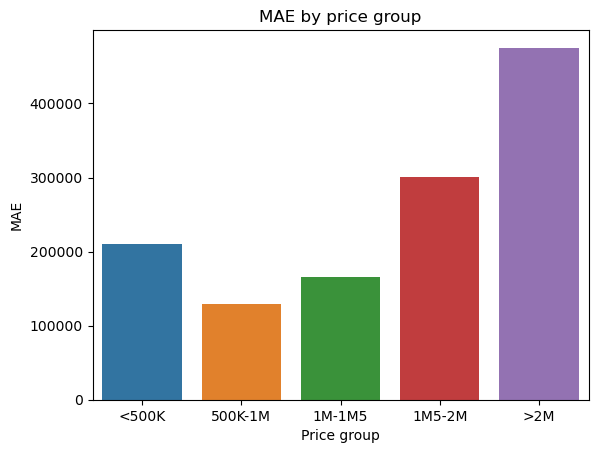

In [184]:
# plotting distribution of MAE across different price groups
sns.barplot(x=df['price_group'],y=df['MAE'])
plt.xlabel('Price group')
plt.ylabel('MAE')
plt.title('MAE by price group')

In the meantime, by using the barplot to compare the percentage of houses which were undervalued, we found that  within the price group of $ 500K to $1M, there are a lots of houses that were undervalued. From this, we can figure out the opportunites to maximize out sales.

Text(0.5, 1.0, 'Under_value_percent by price group')

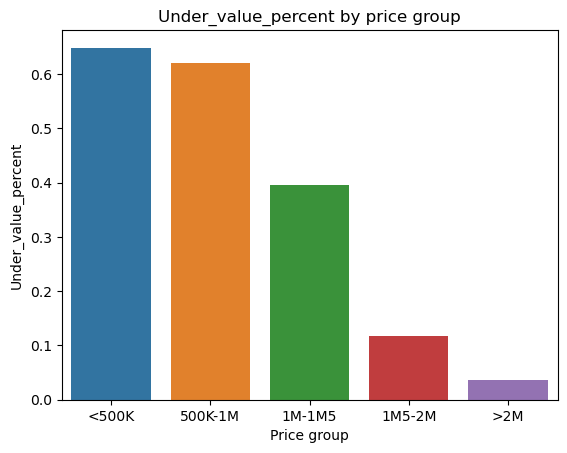

In [185]:
# plotting the distribution of undervalued properties by price group 
sns.barplot(x=df['price_group'],y=df['Under_value_percent'])
plt.xlabel('Price group')
plt.ylabel('Under_value_percent')
plt.title('Under_value_percent by price group')

### 2. Identifying Key Features  

In [186]:
# looking at features that are not zipcode
weight_df[weight_df['Feature'].str.contains('zipcode') == False].sort_values(by = 'Weight', ascending = False)

,Feature,Weight
3,grade,94787.802390
5,condition,43682.695600
2,bathrooms,5619.376975
4,age_sold,1144.558349
0,sqft_living,212.885856
1,sqft_patio,53.101544


`grade` `condition` and `bathrooms` are the top three predictor variables with the highest weight in predicting sale price. 

#### Focusing on Undervalued Properties Sold Between 500K - 1M USD

In [187]:
undervalue_assets = develop_houses[develop_houses['price_group'] == "500K-1M"]

#### Building Grade

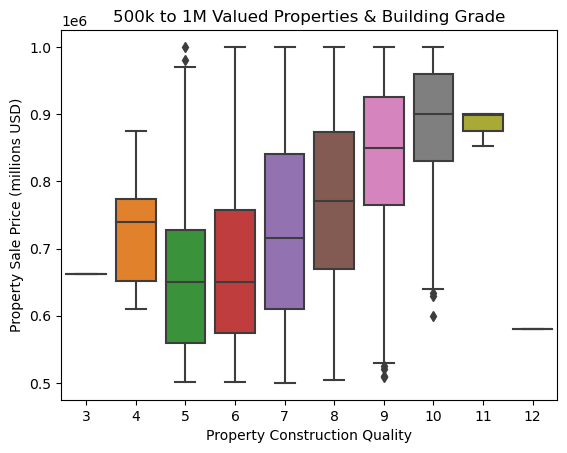

In [189]:
# plotting the rx between building grade and sale price. 
ax = sns.boxplot(x = 'grade', y = 'price', data = undervalue_assets)
ax.set_title("500k to 1M Valued Properties & Building Grade")
ax.set_xlabel("Property Construction Quality")
ax.set_ylabel("Property Sale Price (millions USD)")
plt.savefig("Images/filtered_graderenov.jpg", dpi=300)

We can see that increases in `grade` (i.e., the quality of the construction of the house) contributes to increases in median sale price. 

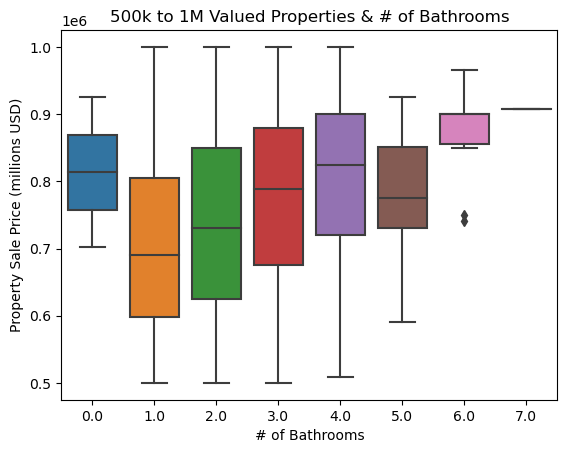

In [192]:
# plotting the rx between # of bathrooms and property sale price
ax = sns.boxplot(x = 'bathrooms', y = 'price', data = undervalue_assets)
ax.set_title("500k to 1M Valued Properties & # of Bathrooms")
ax.set_xlabel("# of Bathrooms")
ax.set_ylabel("Property Sale Price (millions USD)")
plt.savefig("Images/filtered_bathroomrenov.jpg", dpi=300)

We can see that increasing the number of bathrooms in a property contributes to increases of median sale price for the property. 

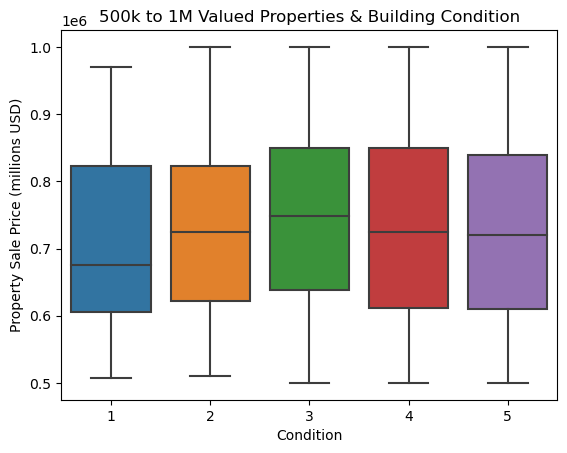

In [193]:
# plotting the rx between building condition and sale price
ax = sns.boxplot(x = 'condition', y = 'price', data = undervalue_assets)
ax.set_title("500k to 1M Valued Properties & Building Condition")
ax.set_xlabel("Condition")
ax.set_ylabel("Property Sale Price (millions USD)")
plt.savefig("Images/filtered_buildingcondition.jpg", dpi=300)

We can see that increasing the building condition increases the median sale price for the property. 

### Residual Distribution of Predictive Model

To evaluate our predictive model, we plot the residual distribution to determine if the results are validated. 

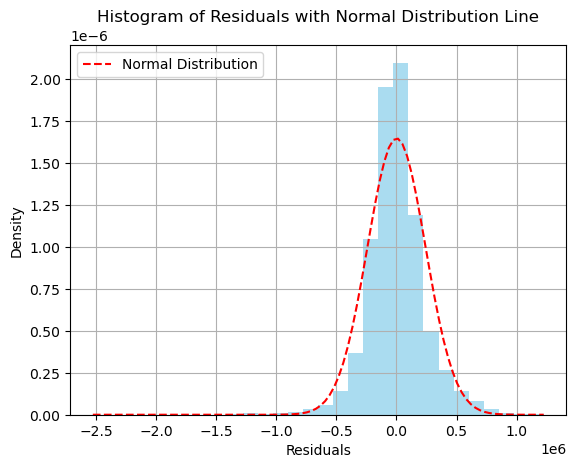

In [194]:
# Plot the histogram
residuals_13.hist(bins=30, density=True, alpha=0.7, color='skyblue')

# Compute mean and standard deviation of residuals
mean = residuals_13.mean()
std = residuals_13.std()

# Create an array of values to plot the normal distribution line
x = np.linspace(residuals_13.min(), residuals_13.max(), 100)
y = stats.norm.pdf(x, mean, std)

# Plot the normal distribution line
plt.plot(x, y, color='red', linestyle='--', label='Normal Distribution')

# Add labels and legend
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Histogram of Residuals with Normal Distribution Line')
plt.legend()

# Saving figure
plt.savefig("Images/residual_distribution.png", format="png")
# Show the plot
plt.show()

Our residuals are normally distributed indicating that our predictive model's performance is validated.

## Recommendations: 
Thus far, we've outlined that our model does a good job at predicting sale price for properties within a given range of 500k to 1M USD. Based on our model's findings, we decided to narrow our reccomendations where our model performs best. We've established that properties valued between 500k & 1M USD represent one of the greatest proportion of undervalued properties. So, our recommendations are: 
1. Improving the overall quality and design of a property can increase its price (+ 98,592 USD) when sold. This can look like the addition of amenities or using better materials in both exterior or interior finish work. 
2. Constructing an additional bathroom in a property can increase its price when sold(+ 7,300 USD). 
3. Improving the condition of a property can increase its price when sold(+ 44,051 USD). This can look like general repairs or maintenance which not only extend the lifespan of the property but its value.